## This notebook is for doing [dogs and cats challenge](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

In [13]:
import sys
sys.path.append('..')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math

from src.evaluate.evaluate import evaluate
from src.train.train_model import train_model
from src.transforms.transforms import data_transforms
from src.visualization.visualize import plot_confusion_matrix
from src.visualization.visualize import visualize_model

print(torch.__version__)
plt.ion()   # interactive mode

1.0.1.post2


In [15]:

# data_dir = '../data'
SUBMISSION_FILE = '../data/submission.csv'
data_dir = '../data/sample/'

CHECK_POINT_PATH = '../models/checkpoint.tar'
MODEL_PATH = '../models/model.pth'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)
print('Train image size: {}'.format(dataset_sizes["train"]))
print('Validation image size: {}'.format(dataset_sizes["val"]))
print('Test image size: {}'.format(dataset_sizes["test"]))

['cats', 'dogs']
Train image size: 200
Validation image size: 40
Test image size: 40


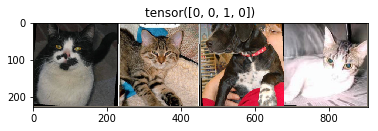

In [16]:
from src.visualization.visualize import imshow

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)

imshow(sample_train_images, title=classes)


### Use pretrained model resnet50

In [17]:
model_conv = torchvision.models.resnet50(pretrained=True)

In [18]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train model (WITHOUT checkpoint at firts time) and save it

In [19]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      dataloaders,
                                                      dataset_sizes,
                                                      device,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

torch.save(model_conv, MODEL_PATH)

checkpoint loaded
Val loss: 0.17265587747097016, Val accuracy: 0.975
Epoch 0/2
----------
train Loss: 0.4959 Acc: 0.8250
val Loss: 0.2456 Acc: 0.8750

Epoch 1/2
----------
train Loss: 0.2765 Acc: 0.8700
val Loss: 0.2199 Acc: 0.9000

Epoch 2/2
----------
train Loss: 0.1732 Acc: 0.9300
val Loss: 0.1124 Acc: 0.9500
New best model found!
New record loss: 0.11244366019964218, previous record loss: 0.17265587747097016

Training complete in 2m 49s
Best val Acc: 0.9500 Best val loss: 0.1124


### Visualize prediction using validation set

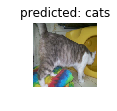

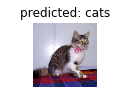

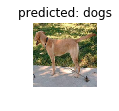

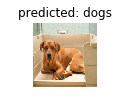

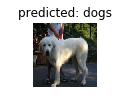

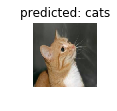

In [20]:
visualize_model(model_conv, dataloaders, device, class_names)

plt.ioff()
plt.show()

### Train model using checkpoint

In [9]:
for param in model_conv.parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

In [10]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      dataloaders,
                                                      dataset_sizes,
                                                      device,
                                                      num_epochs=3,
                                                      checkpoint=checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)
torch.save(model_conv, MODEL_PATH)

checkpoint loaded
Val loss: 0.06340437978506089, Val accuracy: 1.0
Epoch 0/2
----------
train Loss: 0.2013 Acc: 0.9250
val Loss: 0.0681 Acc: 1.0000

Epoch 1/2
----------
train Loss: 0.1433 Acc: 0.9500
val Loss: 0.2727 Acc: 0.8500

Epoch 2/2
----------
train Loss: 0.3130 Acc: 0.8550
val Loss: 0.0983 Acc: 0.9500

Training complete in 8m 19s
Best val Acc: 1.0000 Best val loss: 0.0634


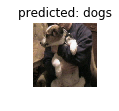

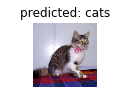

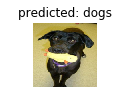

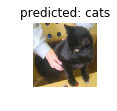

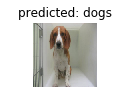

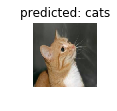

In [11]:
visualize_model(model_conv, dataloaders, device, class_names)

# Evaluate model

In [3]:
model_conv = torch.load(MODEL_PATH)

In [5]:
model_conv.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [6]:
eval_dict = evaluate(model_conv, dataloaders['test'], device)

100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


In [7]:
eval_dict

{'precision': 1.0,
 'recall': 0.95,
 'f1': 0.9743589743589743,
 'roc_auc': 0.975,
 'cm': array([[20,  0],
        [ 1, 19]])}

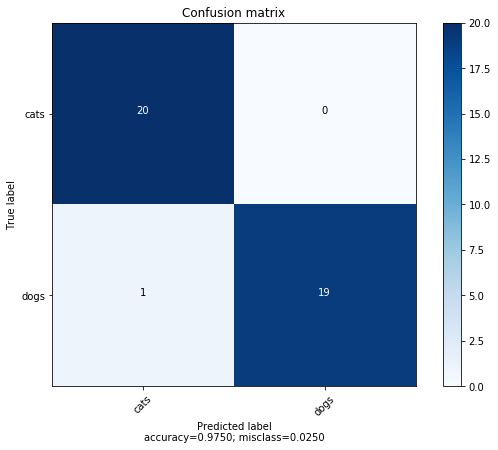

In [11]:
plot_confusion_matrix(eval_dict['cm'], class_names, normalize=False)